In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import seq2seq_model
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt


2023-05-03 19:52:49.970161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('Data/4105819v2474763.csv', index_col=0)
df

,lpt odds,r1 spread,r1 pup,r2 spread,r2 pup,r1_sets_to_win,r2_sets_to_win,enhanced_markov
2018-07-11 16:36:42,0.582314,0.005831,0.076386,0.016807,0.002012,3.0,3.0,0.507162
2018-07-11 16:36:44,0.582350,0.005831,0.076386,0.016807,0.002012,3.0,3.0,0.507162
2018-07-11 16:36:46,0.582387,0.005831,0.074565,0.024288,0.002396,3.0,3.0,0.507162
2018-07-11 16:36:48,0.582423,0.005831,0.072341,0.029768,0.003003,3.0,3.0,0.507162
2018-07-11 16:36:50,0.582460,0.005831,0.070063,0.032151,0.003397,3.0,3.0,0.507162
...,...,...,...,...,...,...,...,...
2018-07-11 19:32:56,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:32:58,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:33:00,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000
2018-07-11 19:33:02,0.000000,1.595506,0.206208,0.048309,0.725523,2.0,0.0,0.000000


In [3]:
data = df.to_numpy()
data

array([[0.58231363, 0.0058309 , 0.07638615, ..., 3.        , 3.        ,
        0.50716188],
       [0.58235018, 0.0058309 , 0.07638615, ..., 3.        , 3.        ,
        0.50716188],
       [0.58238673, 0.0058309 , 0.07456494, ..., 3.        , 3.        ,
        0.50716188],
       ...,
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ],
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ],
       [0.        , 1.59550562, 0.20620843, ..., 2.        , 0.        ,
        0.        ]])

In [4]:
train, test = train_test_split(data, test_size=0.2, shuffle=False)

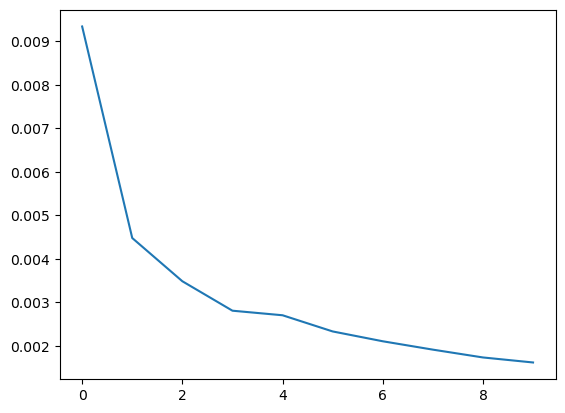

In [5]:
hist = pd.read_csv('train_hist.csv')
plt.plot(hist['mse'])

In [6]:
model = load_model("seq2seq_model")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               163200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 repeat_vector (RepeatVector  (None, 30, 200)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 200)           320800    
                                                                 
 time_distributed (TimeDistr  (None, 30, 10)           2010      
 ibuted)                                                         
                                                        

(370260, 3)
(90, 3)
1/1 [==============================] - 0s 335ms/step
[0.34009632 0.28864214 0.27391848 0.2715688  0.27318117 0.275757
 0.2782572  0.28036883 0.28204364 0.28333405 0.28431383 0.28505117
 0.28560308 0.28601536 0.28632337 0.2865545  0.2867293  0.2868632
 0.28696766 0.28705093 0.28711942 0.28717738 0.28722826 0.2872741
 0.28731656 0.28735644 0.28734142 0.28729892 0.28726268 0.28723192]


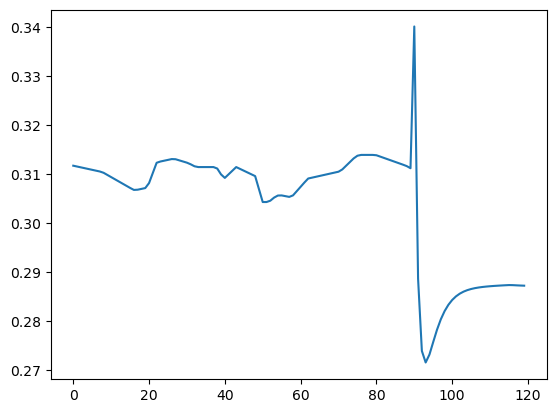

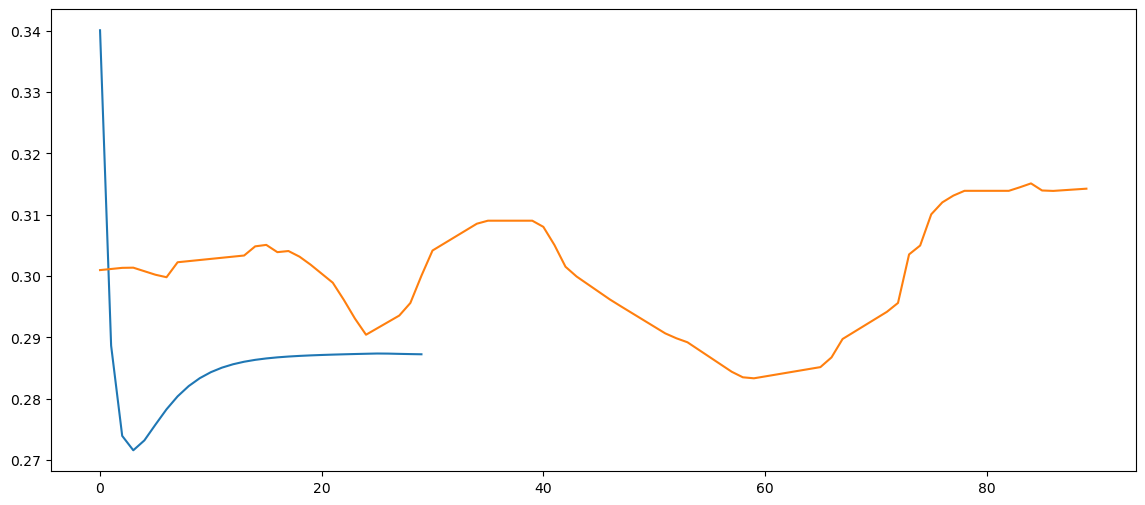

In [8]:
test_x, test_y = seq2seq_model.truncate_data(train, 90, 30, features=range(1))
yhat = seq2seq_model.make_forecast(model, test_x, n_steps=3, n_length=30)
print(yhat[:, 0])
plt.figure(figsize=(14,6))
plt.plot(yhat[:, 0])
plt.plot(test_x[-1, :, 0])
# y = np.concatenate((test_x[-1, :, 0], yhat[:, 0])

In [ ]:
print(predictions.shape)
print(test_out.shape)
print(test_in.shape)
print(len(data))
print(3459 + 3459)
mae = mae(test_out, predictions)
mse = mae**2
rmse = np.sqrt(mse)
print("The mae for this prediction is: " + str(mae))
print("The mse for this prediction is: " + str(mse))
print("The rmse for this prediction is: " + str(rmse))

In [ ]:
validation = df[math.ceil( len(df) * 0.8 ):]
df_pred = pd.DataFrame(predictions, columns = ['pred odds', 'pred r1 spread', 'pred r1 pup', 'pred r2 spread', 'pred r2 pup'])
df_pred.index = validation.index
validation = pd.concat([validation,df_pred],axis=1)
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Time')
plt.ylabel('Implied Probabilities')
plt.plot(validation[['avg','pred odds']])
plt.legend(['Measured values', 'Predictions'], loc='lower right')
plt.show()